In [1]:
using Test, DataFrames, CSV, Printf
using Plots, LightGraphs, StatsBase

include("markov_aux2.jl")
include("markov2.jl")

nᵢ = CSV.read("C:/Users/pierg/Documents/Julia/MMCA-vaccination/population_surface.csv", DataFrame)
sᵢ = Float64.( nᵢ[:, "Superficie"] )
nᵢ = nᵢ[:, "Population"]
N_tot = sum(nᵢ)

G = 3
M = 52
V = 2

Nᵍ= [12009992, 26409793, 8906906] # Data from INE, provisional as of July 1, 2021 

nᵢᵍ =  Nᵍ/sum(Nᵍ) * nᵢ'
nᵢ = sum(nᵢᵍ, dims = 1)
N_tot = sum(nᵢᵍ)

C = [0.5980 0.3849 0.0171
     0.2440 0.7210 0.0350
     0.1919 0.5705 0.2376]

data = CSV.read("C:/Users/pierg/Documents/Julia/MMCA-vaccination/from_to_flow_provinces.csv", DataFrame)
Rᵢⱼ = zeros(M, M)
for count in 1:nrow(data)
    i = data[count,2]
    j = data[count, 3]
    
    Rᵢⱼ[i, j] = data[count, 4]
end
Rᵢⱼ = Rᵢⱼ ./ sum(Rᵢⱼ, dims = 2)

edgelist, Rᵢⱼ = make_edls(Rᵢⱼ)

kᵍ = [11.8, 13.3, 6.6]
kᵍ_h = [3.15, 3.17, 3.28]
kᵍ_w = [1.72, 5.18, 0.0]
pᵍ = [0.3, 1., 0.05] # [0.3, 1.0, 0.05]
# sᵢ = sample([15., 16., 17., 18, 19., 20., 21., 22., 23., 24., 25. ], M)
ξ = 0.01
σ = 2.5;

In [2]:
# FIRST OF ALL RUN THE SIMULATION WITHOUT VACCINATIONS

include("markov_aux2.jl")
include("markov2.jl")

βᴵᵥ = 0.056
βᴬᵥ = 0.5 * βᴵᵥ
ηᵍ = [1, 1, 1] * 0.127
αᵍ = [1, 1, 1] * 0.306
μᵍ = [1, 1, 1] * 0.589

# Rows are the age groups, columns are the vaccination stages
θᵍ = [0.     0.0*(1-0.95);
      0.0  0.0*(1-0.95); 
      0.0  0.0*(1-0.95)]
γᵍ = [0.003  0.003*(1-0.9);
      0.01   0.01*(1-0.9); 
      0.08   0.08*(1-0.9)] 
ωᵍ = [0.  0.0*(1-0.95); 
      0.04  0.04*(1-0.95); 
      0.3  0.3*(1-0.95)]

ζᵍ = [1/7.084, 1/7.084, 1/7.084]
λᵍ = [1/4.084, 1/4.084, 1/4.084]
ψᵍ = [1/7.0, 1/7.0, 1/7.0]
χᵍ = [1/20.0, 1/20.0, 1/20.0]

Λ = 1 / 50 # Waning immunity rate 
Γ = 1 / 100 # Reinfection rate

T = 1200

ϵᵍ = [0.1 , 0.4 , 0.5] * round( N_tot / 200 )
tᶜs = [400, 400+60, T]
ϵᵍs = ϵᵍ .* [0 0 0] # reshape(ϵᵍ, (3, 1))

κ₀s = ones(3) * 0.
ϕs = ones(3) 
δs = ones(3) * 0.

rᵥ = [0., 0.6 ] # Relative risk reduction of the probability of infection
kᵥ = [0., 0.4 ] # Relative risk reduction of the probability of transmission

if (@isdefined epi_params)
    reset_params!(epi_params, population)
end    
population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ);
epi_params = Epidemic_Params(βᴵᵥ, βᴬᵥ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ,
                             ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);

## Initialization of the epidemics

E₀ = population.nᵢᵍ/ N_tot * 1000
A₀ = population.nᵢᵍ / N_tot * 1000
I₀ = population.nᵢᵍ / N_tot * 1000
H₀ = population.nᵢᵍ * 0
R₀ = population.nᵢᵍ / N_tot * 23e5 ### NUMERO REALISTICO?
S₁ = (population.nᵢᵍ .- E₀ .- A₀ .- I₀ .- H₀ .- R₀) .* 0.5

set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)

# run_epidemic_spreading_mmca!(epi_params, population; ϵᵍ, verbose = true)
run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)

In [3]:
reset_params!(epi_params, population)
set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)

# run_epidemic_spreading_mmca!(epi_params, population; ϵᵍ, verbose = true)
run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)

In [4]:
t_peak2

273

In [3]:
# CALL THE SIMULATION WITHOUT VACCINATION "BASELINE"

baseline = (cases = time_series(epi_params, population).cases,
            hosps = time_series(epi_params, population).icus,
            deaths = time_series(epi_params, population).deaths )

# We define the second peak as the next-to-highest one
idx = maxima(baseline.cases).height .== sort(maxima(baseline.cases).height, rev=true)[2]
idx = findall(idx)[1]

t_peak = maxima(baseline.cases).position[1]
t_peak2 = maxima(baseline.cases).position[idx]

h_peak_cases2 = maxima(baseline.cases).height[idx]
h_peak_hosp2 = maxima(baseline.hosps).height[idx]

t_range = t_peak2 - t_peak

184

In [ ]:
### FIRST SCENARIO ANALYSIS: different durations of vaccination rollout, daily amount of vaccines fixed
t_start = round.(Int64, range(1, stop = t_peak2 , length = 50 ) )
policy_d = [30, 60, 90]

cases_h = ones(length(policy_d), length(t_start))
hosps_h = ones(length(policy_d), length(t_start))

cases_p = ones(length(policy_d), length(t_start))
hosps_p = ones(length(policy_d), length(t_start))

cumdeaths = ones(length(policy_d), length(t_start))
cumcases =  ones(length(policy_d), length(t_start))

aux_cases = ones(T)
aux_hosps = ones(T)
aux_deaths = ones(T)

for duration in policy_d
    for i in t_start
        ϵᵍ = [0.1 , 0.4 , 0.5] * round( N_tot / 200 )
        tᶜs = [i, i + duration, T]
        ϵᵍs = ϵᵍ .* [0 1 0]
        
        if (@isdefined epi_params)
            reset_params!(epi_params, population)
        end    
        # population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ);
        epi_params = Epidemic_Params(βᴵᵥ, βᴬᵥ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ,
                                     ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);
        
        set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
        run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false) 
        
        # Auxiliary variables
        aux_cases .= time_series(epi_params, population).cases
        aux_hosps .= time_series(epi_params, population).icus
        aux_deaths .= time_series(epi_params, population).deaths
        
        # Find the position of the second wave's peak for cases and hosps
        max = maxima(aux_cases).height
        if length(max) == 1
            @printf("PROBLEM: T too small, no second wave detected")
        end
        if max[1] == maximum(aux_cases)
            idx_c = max .== sort(max, rev=true)[2]
        else
            idx_c = max .== sort(max, rev=true)[1]
        end
        idx_c = findall(idx_c)[1]
        
        max = maxima(aux_hosps).height
        if max[1] == maximum(aux_hosps)
            idx_h = max .== sort(max, rev=true)[2]
        else
            idx_h = max .== sort(max, rev=true)[1]
        end
        idx_h = findall(idx_h)[1]
        
        cases_p[findall(policy_d .== duration), findall(t_start .== i)] .= maxima(aux_cases).position[idx_c] - t_peak2
        hosps_p[findall(policy_d .== duration), findall(t_start .== i)] .= maxima(aux_hosps).position[idx_h] - maxima(baseline.hosps).position[2]
        
        cases_h[findall(policy_d .== duration), findall(t_start .== i)] .= (maxima(aux_cases).height[idx_c] - h_peak_cases2) / h_peak_cases2
        hosps_h[findall(policy_d .== duration), findall(t_start .== i)] .= (maxima(aux_hosps).height[idx_h] - h_peak_hosp2) / h_peak_hosp2
        
        cumdeaths[findall(policy_d .== duration), findall(t_start .== i)] .= (aux_deaths[T] - baseline.deaths[T]) / baseline.deaths[T]
        cumcases[findall(policy_d .== duration), findall(t_start .== i)] .= (cumsum(aux_cases)[T] - cumsum(baseline.cases)[T]) / cumsum(baseline.cases)[T]
        
        @printf( "%u ", findall(t_start .== i)[1] )
        
    end    
end

# a = DataFrame(hcat(cases_h', hosps_h' , cumdeaths'), 
#     ["cases_30d", "cases_60d", "cases_90d", "hosp_30d", "hosp_60d", "hosp_90d", "deaths_30d", "deaths_60d", "deaths_90d"])
# CSV.write("scenario1_1.csv", a)

In [ ]:
# FIGURES ON THE HEIGHT'S VARIATION OF THE SECOND PEAK
# REDUCED VERSION
fin = 10
pal = palette(:viridis, 1:3)

labs = ["30 days", "60 days", "90 days"]
plt1 = plot(xlab = "Starting day of vaccination", ylab = "Second peak's height variation", 
    legend_title="Rollout", title = "a) Cases variation ", grid = false)
for i in 1:length(labs)   
    plt1 = plot!(t_start[2:fin], reshape(cases_h[i,2:fin], (fin-1) ), label= labs[i], linewidth = 3, linecolor = pal[i] )
end
hline!([0], label= "", linestyle=:dash, color=:black )
vline!([t_peak], label= "", linestyle=:dash, color=:black )

plt2 = plot(xlab = "Starting day of vaccination", ylab = "Cumulative number variation", 
    legend_title="Rollout", title = "b) Deaths variation ", grid = false)
for i in 1:length(labs)   
    plt2 = plot!(t_start, reshape(cumdeaths[i, 1:fin], (fin) ), label= labs[i] , linewidth = 3, linecolor = pal[i] )
end
hline!([0], label= "", linestyle=:dash, color=:black )
vline!([t_peak], label= "", linestyle=:dash, color=:black )


#plt2= plot(t_start, reshape(cases_p , (50) ), label="peak delay" )
#vline!([t_peak], label= "")
#vline!([(t_peak + t_peak2)/2], label= "")
#hline!([0], label= "")

plot(plt1, plt2, layout = (1, 2), legend = true, size = (1000, 350))
# png("height_variation2.png")
# plot(plt1, plt2)

In [ ]:
# FIGURES ON THE DELAY OF THE SECOND PEAK
fin = 50
pal = palette(:viridis, 1:3)

labs = ["30 days", "90 days", "180 days"]
plt1 = plot(xlab = "Starting day of vaccination", ylab = "Delay of second peak", 
    legend_title="Rollout", title = "a) Delay in peak of cases", grid = false)
for i in 1:3    
    plt1 = plot!(t_start[1:fin], reshape(cases_p[i,1:fin], (fin) ), label= labs[i] , linewidth = 3, linecolor = pal[i] )
end
hline!([0], label= "", linestyle=:dash, color=:black )
vline!([t_peak], label= "", linestyle=:dash, color=:black )

labs = ["30 days", "90 days", "180 days"]
plt2 = plot(xlab = "Starting day of vaccination", ylab = "Delay of second peak", 
    legend_title="Rollout", title = "b) Delay in peak of hospitaliziations ", grid = false)
for i in 1:3    
    plt2 = plot!(t_start[1:fin], reshape(hosps_p[i,1:fin], (fin) ), label= labs[i] , linewidth = 3, linecolor = pal[i] )
end
hline!([0], label= "", linestyle=:dash, color=:black )
vline!([t_peak], label= "", linestyle=:dash, color=:black )

plot(plt1, plt2, size = (1000, 350))
png("delay_second_peak.png")

In [68]:
### SECOND SCENARIO ANALYSIS: different priority groups
# Duration fixed to 30 days

policy = [1/3  1/3  1/3;
            0.8  0.1 0.1;
            0.1  0.8 0.1;
            0.1  0.1 0.8] * round( N_tot / 200 )
t_start = round.(Int64, range(1, stop = t_peak2 , length = 50 ) )

PG_cases_h = ones( size(policy)[1], length(t_start)) #PG stands for priority groups
PG_hosps_h = ones( size(policy)[1], length(t_start))

PG_cases_p = ones( size(policy)[1], length(t_start))
PG_hosps_p = ones( size(policy)[1], length(t_start))

PG_cumdeaths = ones( size(policy)[1], length(t_start))
PG_cumcases = ones( size(policy)[1], length(t_start))

aux_cases = ones(T)
aux_hosps = ones(T)
aux_deaths = ones(T)

for d in 1:size(policy)[1]
    for i in t_start
        ϵᵍ = reshape(policy[d, 1:3], (3))
        tᶜs = [i, i + 30, T]
        ϵᵍs = ϵᵍ .* [0 1 0]
        
        if (@isdefined epi_params)
            reset_params!(epi_params, population)
        end    
        # population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ);
        epi_params = Epidemic_Params(βᴵᵥ, βᴬᵥ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ,
                                     ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);
        
        set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
        run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false) 
        
        aux_cases .= time_series(epi_params, population).cases
        aux_hosps .= time_series(epi_params, population).icus
        aux_deaths .= time_series(epi_params, population).deaths
        
        max = maxima(aux_cases).height
        if length(max) == 1
            @printf("PROBLEM: T too small, no second wave detected")
        end
        if max[1] == maximum(aux_cases)
            idx_c = max .== sort(max, rev=true)[2]
        else
            idx_c = max .== sort(max, rev=true)[1]
        end
        idx_c = findall(idx_c)[1]
        
        max = maxima(aux_hosps).height
        if max[1] == maximum(aux_hosps)
            idx_h = max .== sort(max, rev=true)[2]
        else
            idx_h = max .== sort(max, rev=true)[1]
        end
        idx_h = findall(idx_h)[1]
        
        # Position second peak
        PG_cases_p[d, findall(t_start .== i)] .= maxima(aux_cases).position[idx_c] - t_peak2
        PG_hosps_p[d, findall(t_start .== i)] .= maxima(aux_hosps).position[idx_h] - maxima(baseline.hosps).position[idx]
        
        # Height second peak (relative)
        PG_cases_h[d, findall(t_start .== i)] .= (maxima(aux_cases).height[idx_c] - h_peak_cases2) / h_peak_cases2
        PG_hosps_h[d, findall(t_start .== i)] .= (maxima(aux_hosps).height[idx_h] - h_peak_hosp2) / h_peak_hosp2
        
        # Overall relative decrease in deaths / infections
        PG_cumdeaths[findall(1:size(policy)[1] .== d), findall(t_start .== i)] .= (aux_deaths[T] - baseline.deaths[T]) / baseline.deaths[T]
        PG_cumcases[findall(1:size(policy)[1] .== d), findall(t_start .== i)] .= (cumsum(aux_cases)[T] - cumsum(baseline.cases)[T]) / cumsum(baseline.cases)[T]
        
        @printf( "%u ", findall(t_start .== i)[1] )
    end    
end

# b = DataFrame(hcat(PG_cases_h', PG_hosps_h' , PG_cumdeaths'), 
#     ["cases_hom", "cases_young", "cases_adult", "cases_old", "hosp_hom", "hosp_young", "hosp_adult", "hosp_old", "deaths_hom", "deaths_young", "deaths_adult", "deaths_old"])
# CSV.write("scenario2_1.csv", b)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

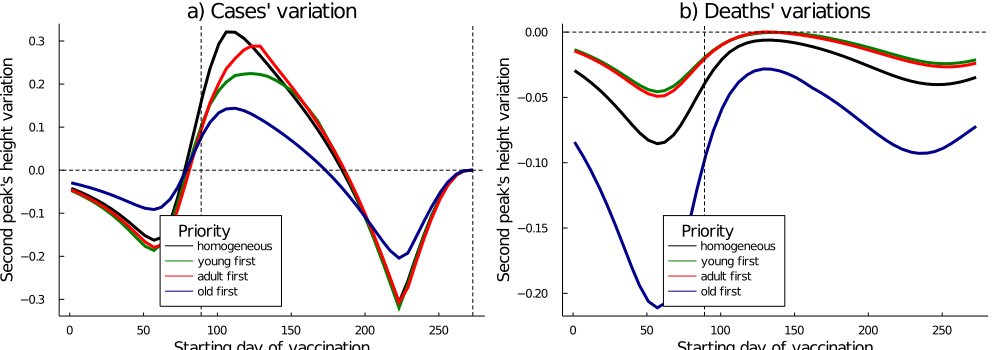

In [94]:
# FIGURES ON THE HEIGHT'S VARIATION OF THE SECOND PEAK
# REDUCED VERSION
fin = 50
PG_pal = [:black, :green, :red, :darkblue]# palette([:black, :blue], 1:4)

labs = ["homogeneous", "young first", "adult first", "old first"]
plt1 = plot(xlab = "Starting day of vaccination", ylab = "Second peak's height variation", 
    legend_title="Priority", title = "a) Cases' variation", grid = false)
for i in 1:length(labs)   
    plt1 = plot!(t_start[1:fin], reshape(PG_cases_h[i,1:fin], (fin) ), label= labs[i], linewidth = 3, linecolor = PG_pal[i] )
end
hline!([0], label= "", linestyle=:dash, color=:black )
vline!([t_peak], label= "", linestyle=:dash, color=:black )
vline!([t_peak2], label= "", linestyle=:dash, color=:black )

plt2 = plot(xlab = "Starting day of vaccination", ylab = "Second peak's height variation", 
    legend_title="Priority", title = "b) Deaths' variations", grid = false)
for i in 1:length(labs)   
    plt2 = plot!(t_start, reshape(PG_cumdeaths[i, 1:fin], (fin) ), label= labs[i], linewidth = 3, linecolor = PG_pal[i] )
end
hline!([0], label= "", linestyle=:dash, color=:black )
vline!([t_peak], label= "", linestyle=:dash, color=:black )


# plot(plt1, plt2, plt3, layout = (1,3), legend=true, size = (1000, 1000))
plot(plt1, plt2, legend=:bottom, size = (1000, 350))
# png("priority_height2.png")

In [71]:
### THIRD SCENARIO ANALYSIS: fixed number of total vaccines, fast and short vs slow and long rollout 

V_tot = round( N_tot / 100 ) * 30 # equivalent to 1% of the population vaccinated per day for thirty days
policy_d = [30, 90, 180]
# t_start = round.(Int64, range(1, stop = t_peak + floor(t_range/2) , length = 50 ) )
t_start = round.(Int64, range(1, stop = t_peak2 , length = 50 ) )

TF_cases_h = ones(length(policy_d), length(t_start)) # TF stands for total fixed 
TF_hosps_h = ones(length(policy_d), length(t_start))

TF_cases_p = ones(length(policy_d), length(t_start))
TF_hosps_p = ones(length(policy_d), length(t_start))

TF_cumdeaths = ones(length(policy_d), length(t_start))
TF_cumcases = ones(length(policy_d), length(t_start))

aux_cases = ones(T)
aux_hosps = ones(T)
aux_deaths = ones(T)

for duration in policy_d
    for i in t_start
        ϵᵍ = [0.1 , 0.4 , 0.5] * round( V_tot / duration )
        tᶜs = [i, i + duration, T]
        ϵᵍs = ϵᵍ .* [0 1 0]
        
        if (@isdefined epi_params)
            reset_params!(epi_params, population)
        end    
        # population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ);
        epi_params = Epidemic_Params(βᴵᵥ, βᴬᵥ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ,
                                     ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);
        
        set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
        run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false) 
        
        aux_cases .= time_series(epi_params, population).cases
        aux_hosps .= time_series(epi_params, population).icus
        aux_deaths .= time_series(epi_params, population).deaths
        
        max = maxima(aux_cases).height
        if length(max) == 1
            @printf("PROBLEM: T too small, no second wave detected")
        end
        if max[1] == maximum(aux_cases)
            idx_c = max .== sort(max, rev=true)[2]
        else
            idx_c = max .== sort(max, rev=true)[1]
        end
        idx_c = findall(idx_c)[1]
        
        max = maxima(aux_hosps).height
        if max[1] == maximum(aux_hosps)
            idx_h = max .== sort(max, rev=true)[2]
        else
            idx_h = max .== sort(max, rev=true)[1]
        end
        idx_h = findall(idx_h)[1]
        
        TF_cases_p[findall(policy_d .== duration), findall(t_start .== i)] .= maxima(aux_cases).position[idx_c] - t_peak2
        TF_hosps_p[findall(policy_d .== duration), findall(t_start .== i)] .= maxima(aux_hosps).position[idx_h] - maxima(baseline.hosps).position[2]
        
        TF_cases_h[findall(policy_d .== duration), findall(t_start .== i)] .= (maxima(aux_cases).height[idx_c] - h_peak_cases2) / h_peak_cases2
        TF_hosps_h[findall(policy_d .== duration), findall(t_start .== i)] .= (maxima(aux_hosps).height[idx_h] - h_peak_hosp2) / h_peak_hosp2
        
        TF_cumdeaths[findall(policy_d .== duration), findall(t_start .== i)] .= (aux_deaths[T] - baseline.deaths[T]) / baseline.deaths[T]
        TF_cumcases[findall(policy_d .== duration), findall(t_start .== i)] .= (cumsum(aux_cases)[T] - cumsum(baseline.cases)[T]) / cumsum(baseline.cases)[T]
        
        
        @printf( "%u ", findall(t_start .== i)[1] )
        
    end    
end

# c = DataFrame(hcat(TF_cases_h', TF_hosps_h' , TF_cumdeaths'), 
#     ["cases_TF30d", "cases_TF90d", "cases_TF180d", "hosp_TF30d", "hosp_TF90d", "hosp_TF180d", "deaths_TF30d", "deaths_TF90d", "deaths_TF180d"])
# CSV.write("scenario3_1.csv", c)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

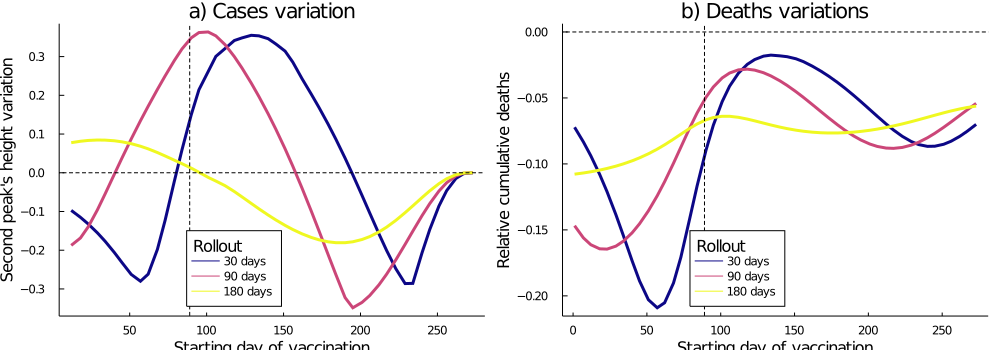

In [101]:
# FIGURES ON THE HEIGHT'S VARIATION OF THE SECOND PEAK
# REDUCED VERSION
fin = 50
pal = palette(:plasma, 1:3)

labs = ["30 days", "90 days", "180 days"]
plt1 = plot(xlab = "Starting day of vaccination", ylab = "Second peak's height variation", 
    legend_title="Rollout", title = "a) Cases variation", grid = false)
for i in 1:length(labs)   
    plt1 = plot!(t_start[3:fin], reshape(TF_cases_h[i,3:fin], (fin-2) ), label= labs[i], linewidth = 3, linecolor = pal[i] )
end
hline!([0], label= "", linestyle=:dash, color=:black )
vline!([t_peak], label= "", linestyle=:dash, color=:black )

plt2 = plot(xlab = "Starting day of vaccination", ylab = "Relative cumulative deaths", 
    legend_title="Rollout", title = "b) Deaths variations", grid = false)
for i in 1:length(labs)   
    plt2 = plot!(t_start, reshape(TF_cumdeaths[i, 1:fin], (fin) ), label= labs[i], linewidth = 3, linecolor = pal[i] )
end
hline!([0], label= "", linestyle=:dash, color=:black )
vline!([t_peak], label= "", linestyle=:dash, color=:black )


#plt2= plot(t_start, reshape(cases_p , (50) ), label="peak delay" )
#vline!([t_peak], label= "")
#vline!([(t_peak + t_peak2)/2], label= "")
#hline!([0], label= "")

plot(plt1, plt2, layout = (1,2), legend=:bottom, size = (1000, 350))
# png("slowvsfast.png")

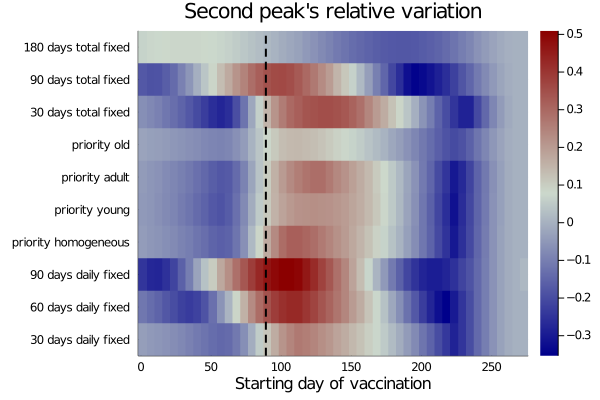

In [15]:
### HEATMAP WITH THE RELATIVE VARIATION OF THE SECOND PEAK'S HEIGHT ###
a = CSV.read("scenarioA.csv", DataFrame)[:,[1, 2, 3]]
b = CSV.read("scenarioB.csv", DataFrame)[:,[1, 2, 3, 4]]
c = CSV.read("scenarioC.csv", DataFrame)[:,[1,2,3]]
t_peak2 = 273
t_start = round.(Int64, range(1, stop = t_peak2 , length = 50 ) )

strategies_names = ["30 days daily fixed", "60 days daily fixed", "90 days daily fixed", 
    "priority homogeneous", "priority young", "priority adult", "priority old", 
    "30 days total fixed", "90 days total fixed", "180 days total fixed"]

heat = heatmap(t_start[1:50], strategies_names, Matrix(hcat(a, b, c))', color = :bluesreds, 
    title = "Second peak's relative variation", xlab = "Starting day of vaccination" )
vline!([t_peak], label="", color = :black, linewidth = 2, linestyle = :dash)
# png(heat, "heatmap_cases.png")

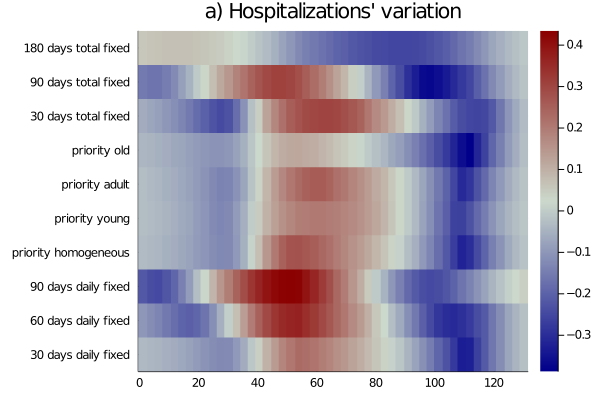

In [6]:
### HEATMAP WITH THE RELATIVE VARIATION OF HOSPITALIZATIONS ###
a = CSV.read("scenarioA.csv", DataFrame)[:,[4, 5, 6]]
b = CSV.read("scenarioB.csv", DataFrame)[:,[5, 6, 7, 8]]
c = CSV.read("scenarioC.csv", DataFrame)[:,[4, 5, 6]]
t_start = round.(Int64, range(1, stop = t_peak_2 , length = 50 ) )

# strategies_names = ["DF_30d", "DF_60d", "DF_90d", "PG_hom", "PG_young", "PG_adult", "PG_old", "TF_30d", "TF_90d", "TF_180d"]
strategies_names = ["30 days daily fixed", "60 days daily fixed", "90 days daily fixed", 
    "priority homogeneous", "priority young", "priority adult", "priority old", 
    "30 days total fixed", "90 days total fixed", "180 days total fixed"]

heat = heatmap(t_start[1:50], strategies_names, Matrix(hcat(a, b, c))', color = :bluesreds, 
    title = "a) Hospitalizations' variation" )
# vline!([t_peak], label="", color = :black, linewidth = 2, linestyle = :dash)
# png(heat, "heatmap_cases.png")

In [24]:
### HEATMAP WITH THE VARIATION OF CUMULATIVE NUMBER OF DEAD PEOPLE ###
a = CSV.read("scenario1.csv", DataFrame)[:,[7, 8, 9]]
b = CSV.read("scenario2.csv", DataFrame)[:,[9, 10, 11, 12]]
c = CSV.read("scenario3.csv", DataFrame)[:,[7, 8, 9]]
t_start = round.(Int64, range(1, stop = t_peak2 , length = 50 ) )

strategies_names = ["30 days daily fixed", "60 days daily fixed", "90 days daily fixed", "priority homogeneous", "priority young", "priority adult", "priority old", "30 days total fixed", "90 days total fixed", "180 days total fixed"]

heat2 = heatmap(t_start[1:50], strategies_names, Matrix(hcat(a, b, c))', 
    title = "Deaths' relative variation", 
    xlab = "Starting day of vaccination")
vline!([t_peak], label="", color = :black, linewidth = 2, linestyle = :dash)
# png("heatmap_deaths.png")
# savefig(heat2, "provissima.png", bbox_inches= "tight")

LoadError: MethodError: no method matching savefig(::Plots.Plot{Plots.GRBackend}, ::String; bbox_inches="tight")
[0mClosest candidates are:
[0m  savefig(::Plots.Plot, ::AbstractString) at C:\Users\pierg\.julia\packages\Plots\uCh2y\src\output.jl:111[91m got unsupported keyword argument "bbox_inches"[39m

In [54]:
fin = 5
pal = palette(:viridis, 1:3)
t_start = round.(Int64, range(201, stop = t_peak2 , length = fin ) )
labs = ["30 days", "90 days", "180 days"]
plt1 = plot(xlab = "Starting day of vaccination", ylab = "Delay of second peak", 
    legend_title="Rollout", title = "Delay in the second wave", grid = false, 
    legend= :topleft)
for i in 1:3    
    plt1 = plot!(t_start[1:fin], reshape(cases_p[i,1:fin], (fin) ), label= labs[i] , linewidth = 3, linecolor = pal[i] )
end
hline!([0], label= "", linestyle=:dash, color=:black )
vline!([t_peak], label= "", linestyle=:dash, color=:black )

fin = 37
a = CSV.read("scenario1_delay.csv", DataFrame)
t_start = round.(Int64, range(1, stop = t_peak2 , length = 50 ) )
labs = ["30 days", "90 days", "180 days"]
for i in 1:3    
    plt1 = plot!(t_start[1:fin], reshape(a[1:fin, i], (fin) ), label= "" , linewidth = 3, linecolor = pal[i] )
end
hline!([0], label= "", linestyle=:dash, color=:black )
vline!([t_peak], label= "", linestyle=:dash, color=:black )
# png("delay_second_peak1.png")

In [3]:
df = open(GzipDecompressorStream, "20210509_maestra_1_mitma_municipio.txt.gz", "r") do stream
    CSV.read(stream, DataFrame)
end

# CSV.read(readline(df))

,fecha,origen,destino,periodo,distancia,viajes,viajes_km
,Int64,String15,String15,Int64,String15,Float64,Float64
1,20210509,01001_AM,01001_AM,0,002-005,18.96,68.384
2,20210509,01001_AM,01001_AM,0,005-010,51.65,363.892
3,20210509,01001_AM,01001_AM,0,010-050,73.013,881.204
4,20210509,01001_AM,01001_AM,1,002-005,46.186,157.144
5,20210509,01001_AM,01001_AM,1,005-010,35.91,286.222
6,20210509,01001_AM,01001_AM,1,010-050,28.796,322.454
7,20210509,01001_AM,01001_AM,2,002-005,32.824,131.6
8,20210509,01001_AM,01001_AM,2,005-010,24.38,202.957
9,20210509,01001_AM,01001_AM,2,010-050,69.456,790.766
